In [2]:
#Uncomment for colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [27]:
FEATURE_PATH = '/content/drive/MyDrive/MM/tvsum/features'
# video_dataset = ['-esJrBWj2d8', '98MoyGZKHXc']
video_dataset = ['98MoyGZKHXc']

In [28]:
param = {'VIDEO':0, 'AUDIO': 0, 'FRAMES':0}

for video_id in video_dataset:
    for features in ['vggish', 'flow', 'rgb']:
        stack = np.load(os.path.join(FEATURE_PATH, f'{video_id}_{features}.npy'))

        if features == 'vggish':
            if stack.shape[0] > param['AUDIO']:
                param['AUDIO'] = stack.shape[0]

            if stack.shape[0] < param['FRAMES']:
                param['FRAMES'] = stack.shape[0]
        else:
            if stack.shape[0] > param['VIDEO']:
                param['VIDEO'] = stack.shape[0]

            if stack.shape[0] < param['FRAMES']:
                param['FRAMES'] = stack.shape[0]

print(param)

{'VIDEO': 179, 'AUDIO': 195, 'FRAMES': 0}


In [29]:
param['FRAMES'] = 179
param

{'AUDIO': 195, 'FRAMES': 179, 'VIDEO': 179}

In [33]:
def rep_titles(features):
    new_stack = []
    new_stack.append(features[0])
    new_stack.extend(new_stack * param['FRAMES'])
    new_stack = torch.stack(new_stack)
    return new_stack

def rep_captions(features):
    reps = param['FRAMES'] // features.shape[0]
    remainder = param['FRAMES'] % features.shape[0]
    new_stack = []
    for frame_ind in range(features.shape[0]):
        tmp = []
        tmp.append(features[frame_ind])

        if frame_ind == features.shape[0] - 1:
            new_stack.extend(tmp * (reps + remainder))
        else:
            new_stack.extend(tmp * reps)

    new_stack = torch.stack(new_stack)
    return new_stack

def fill_missing_features(method, feature_size):
    if method == 'random':
        return torch.rand(1, feature_size)
    elif method == 'zero':
        return torch.zeros(1, feature_size).float()


def pad_segment(feature, max_feature_len, pad_idx):
    S, D = feature.shape
    assert S <= max_feature_len
    # pad
    l, r, t, b = 0, 0, 0, max_feature_len - S
    feature = F.pad(feature, [l, r, t, b], value=pad_idx)
    return feature

def crop_a_segment(feature, start_idx, end_idx):
    S, D = feature.shape

    # handles the case when a segment is too small
    if start_idx == end_idx:
        # if the small segment occurs in the end of a video
        # [S:S] -> [S-1:S]
        if start_idx == S:
            start_idx -= 1
        # [S:S] -> [S:S+1]
        else:
            end_idx += 1
    feature = feature[start_idx:end_idx, :]

    if len(feature) == 0:
        return None
    else:
        return feature


def load_features_from_npy(feature_names_list, video_id,
                           pad_idx, get_full_feat=False):

    supported_feature_names = {'i3d_features', 'vggish_features', 'caption_features', 'title_features'}
    assert isinstance(feature_names_list, list)
    assert len(feature_names_list) > 0
    assert set(feature_names_list).issubset(supported_feature_names)

    stacks = {}
    if get_full_feat:
        stacks['orig_feat_length'] = {}

    if 'vggish_features' in feature_names_list:

        try:
            stack_vggish = np.load(os.path.join(FEATURE_PATH, f'{video_id}_vggish.npy'))
            stack_vggish = torch.from_numpy(stack_vggish).float()

            if get_full_feat:
                stacks['orig_feat_length']['audio'] = stack_vggish.shape[0]
                if stack_vggish.shape[0] > param['FRAMES']:
                    stack_vggish = crop_a_segment(stack_vggish, start_idx = 0, end_idx = param['FRAMES'])
                else:
                    stack_vggish = pad_segment(stack_vggish, param['FRAMES'], pad_idx=0)

        except FileNotFoundError as e:
            print(e)
            stack_vggish = None

        stacks['audio'] = stack_vggish

    # not elif
    if 'i3d_features' in feature_names_list:
        try:
            stack_rgb = np.load(os.path.join(FEATURE_PATH, f'{video_id}_rgb.npy'))
            stack_flow = np.load(os.path.join(FEATURE_PATH, f'{video_id}_flow.npy'))
            stack_rgb = torch.from_numpy(stack_rgb).float()
            stack_flow = torch.from_numpy(stack_flow).float()

            assert stack_rgb.shape == stack_flow.shape
            if get_full_feat:
                stacks['orig_feat_length']['rgb'] = stack_rgb.shape[0]
                stacks['orig_feat_length']['flow'] = stack_flow.shape[0]
                
                if stack_rgb.shape[0] > param['FRAMES']:
                    stack_rgb = crop_a_segment(stack_rgb, start_idx = 0, end_idx = param['FRAMES'])
                else:
                    stack_rgb = pad_segment(stack_rgb, param['FRAMES'], pad_idx=0)

                if stack_flow.shape[0] > param['FRAMES']:
                    stack_flow = crop_a_segment(stack_rgb, start_idx = 0, end_idx = param['FRAMES'])
                else:
                    stack_flow = pad_segment(stack_flow, param['FRAMES'], pad_idx=0)


                # stack_rgb = pad_segment(stack_rgb, param['VIDEO'], pad_idx=0)
                # stack_flow = pad_segment(stack_flow, param['VIDEO'], pad_idx=0)

        except FileNotFoundError(e):
            print(e)
            stack_rgb = None
            stack_flow = None
        stacks['rgb'] = stack_rgb
        stacks['flow'] = stack_flow

    if 'caption_features' in feature_names_list:
        try:
            stack_captions = np.load(os.path.join(FEATURE_PATH, f'{video_id}_manual_cc_embedding.npy'))
            stack_captions = torch.from_numpy(stack_captions).float()

            if get_full_feat:
                stacks['orig_feat_length']['caption'] = stack_captions.shape[0]
                if stack_captions.shape[0] > param['FRAMES']:
                    stack_captions = crop_a_segment(stack_captions, start_idx = 0, end_idx = param['FRAMES'])
                else:
                    stack_captions = rep_captions(stack_captions)

        except FileNotFoundError as e:
            print(e)
            stack_captions = None

        stacks['caption'] = stack_captions

    if 'title_features' in feature_names_list:
        try:
            stack_title = np.load(os.path.join(FEATURE_PATH, f'{video_id}_title.npy'))
            stack_title = stack_title.reshape(1, -1)
            stack_title = torch.from_numpy(stack_title).float()

            if get_full_feat:
                stacks['orig_feat_length']['title'] = stack_title.shape[0]
                if stack_title.shape[0] > param['FRAMES']:
                    stack_title = crop_a_segment(stack_title, start_idx = 0, end_idx = param['FRAMES'])
                else:
                    stack_title = rep_captions(stack_title)

        except FileNotFoundError as e:
            print(e)
            stack_captions = None

        stacks['title'] = stack_title
    
    else:
        raise Exception(f'This methods is not implemented for {feature_names_list}')

    # if 'i3d_features' not in feature_names_list and 'vggish_features' not in feature_names_list:
    #     raise Exception(f'This methods is not implemented for {feature_names_list}')

    return stacks

In [49]:
class AudioVideoFeaturesDataset(Dataset):
    
    def __init__(self, 
                 video_features_path, video_feature_name, 
                 audio_features_path, audio_feature_name, 
                 caption_features_path, caption_feature_name,
                 title_features_path, title_feature_name,
                 device, pad_idx, get_full_feat):
      
        self.video_features_path = video_features_path
        self.video_feature_name = f'{video_feature_name}_features'
        self.audio_features_path = audio_features_path
        self.audio_feature_name = f'{audio_feature_name}_features'
        self.caption_features_path = caption_features_path
        self.caption_feature_name = f'{caption_feature_name}_features'
        self.title_features_path = title_features_path
        self.title_feature_name = f'{title_feature_name}_features'
        self.feature_names_list = [self.video_feature_name, 
                                   self.audio_feature_name,
                                   self.caption_feature_name,
                                   self.title_feature_name]
        self.pad_idx = pad_idx
        self.get_full_feat = get_full_feat
        self.device = device
        
        if self.video_feature_name == 'i3d_features':
            self.video_feature_size = 1024
        else:
            raise Exception(f'Inspect: "{self.video_feature_name}"')
            
        if self.audio_feature_name == 'vggish_features':
            self.audio_feature_size = 128
        else:
            raise Exception(f'Inspect: "{self.audio_feature_name}"')

        if self.caption_feature_name == 'caption_features':
            self.cap_feature_size = 512
        else:
            raise Exception(f'Inspect: "{self.video_feature_name}"')

        if self.title_feature_name == 'title_features':
            self.title_feature_size = 512
        else:
            raise Exception(f'Inspect: "{self.video_feature_name}"')
            
    
    def __getitem__(self, indices):
        video_ids = []
        vid_stacks_rgb, vid_stacks_flow, aud_stacks, cap_stacks, title_stacks = [], [], [], [], []

        if type(indices) == int:
            video_id = video_dataset[indices]
            
            stack = load_features_from_npy(self.feature_names_list, video_id,
                           self.pad_idx, self.get_full_feat)
            
            vid_stack_rgb, vid_stack_flow, aud_stack, cap_stack, title_stack = stack['rgb'], stack['flow'], stack['audio'], stack['caption'], stack['title']

            # either both None or both are not None (Boolean Equivalence)
            both_are_None = vid_stack_rgb is None and vid_stack_flow is None
            none_is_None = vid_stack_rgb is not None and vid_stack_flow is not None
            assert both_are_None or none_is_None

            # sometimes vid_stack and aud_stack are empty after the filtering. 
            # we replace it with noise.
            # tied with assertion above
            if (vid_stack_rgb is None) and (vid_stack_flow is None):
                # print(f'RGB and FLOW are None. Zero (1, D) @: {video_id}')
                vid_stack_rgb = fill_missing_features('zero', self.video_feature_size)
                vid_stack_flow = fill_missing_features('zero', self.video_feature_size)

            if aud_stack is None:
                # print(f'Audio is None. Zero (1, D) @: {video_id}')
                aud_stack = fill_missing_features('zero', self.audio_feature_size)

            if cap_stack is None:
                # print(f'Caption is None. Zero (1, D) @: {video_id}')
                cap_stack = fill_missing_features('zero', self.cap_feature_size)

            if title_stack is None:
                # print(f'Title is None. Zero (1, D) @: {video_id}')
                title_stack = fill_missing_features('zero', self.title_feature_size)

            # append info for this index to the lists
            video_ids = video_id
            vid_stacks_rgb = vid_stack_rgb
            vid_stacks_flow = vid_stack_flow
            aud_stacks = aud_stack
            cap_stacks = cap_stack
            title_stacks = title_stack

        else: 
            for idx in range(indices):
                video_id = video_dataset[idx]
                
                stack = load_features_from_npy(self.feature_names_list, video_id,
                              self.pad_idx, self.get_full_feat)
                
                vid_stack_rgb, vid_stack_flow, aud_stack, cap_stack, title_stack = stack['rgb'], stack['flow'], stack['audio'], stack['caption'], stack['title']

                # either both None or both are not None (Boolean Equivalence)
                both_are_None = vid_stack_rgb is None and vid_stack_flow is None
                none_is_None = vid_stack_rgb is not None and vid_stack_flow is not None
                assert both_are_None or none_is_None

                # sometimes vid_stack and aud_stack are empty after the filtering. 
                # we replace it with noise.
                # tied with assertion above
                if (vid_stack_rgb is None) and (vid_stack_flow is None):
                    # print(f'RGB and FLOW are None. Zero (1, D) @: {video_id}')
                    vid_stack_rgb = fill_missing_features('zero', self.video_feature_size)
                    vid_stack_flow = fill_missing_features('zero', self.video_feature_size)

                if aud_stack is None:
                    # print(f'Audio is None. Zero (1, D) @: {video_id}')
                    aud_stack = fill_missing_features('zero', self.audio_feature_size)

                if cap_stack is None:
                    # print(f'Caption is None. Zero (1, D) @: {video_id}')
                    cap_stack = fill_missing_features('zero', self.cap_feature_size)

                if title_stack is None:
                    # print(f'Title is None. Zero (1, D) @: {video_id}')
                    title_stack = fill_missing_features('zero', self.title_feature_size)

                # append info for this index to the lists
                video_ids.append(video_id)
                vid_stacks_rgb.append(vid_stack_rgb)
                vid_stacks_flow.append(vid_stack_flow)
                aud_stacks.append(aud_stack)
                cap_stacks.append(cap_stack)
                title_stacks.append(title_stack)
            
        # [4] see ActivityNetCaptionsDataset.__getitem__ documentation
        # padded with pad_idx expected to be summed later
        vid_stacks_rgb = pad_sequence(vid_stacks_rgb, batch_first=True, padding_value=self.pad_idx)
        vid_stacks_flow = pad_sequence(vid_stacks_flow, batch_first=True, padding_value=self.pad_idx)
        aud_stacks = pad_sequence(aud_stacks, batch_first=True, padding_value=self.pad_idx)
        cap_stacks = pad_sequence(cap_stacks, batch_first=True, padding_value=self.pad_idx)
        title_stacks = pad_sequence(title_stacks, batch_first=True, padding_value=self.pad_idx)
                
        batch_dict = {
            'video_ids': video_ids,
            'feature_stacks': {
                'rgb': vid_stacks_rgb.to(self.device),
                'flow': vid_stacks_flow.to(self.device),
                'audio': aud_stacks.to(self.device),
                'caption': cap_stacks.to(self.device),
                'title': title_stacks.to(self.device),
            }
        }

        return batch_dict
        
    def __len__(self):
        return len(video_dataset)

In [48]:
dataset = AudioVideoFeaturesDataset(FEATURE_PATH, 'i3d', 
                                    FEATURE_PATH, 'vggish',
                                    FEATURE_PATH, 'caption',
                                    FEATURE_PATH, 'title',
                                    device='cpu', pad_idx=0, get_full_feat=True)

train_loader = DataLoader(dataset, batch_size=1)

for i, item in enumerate(train_loader):
    print(item['video_ids'])
    print(item['feature_stacks']['rgb'].shape)
    print(item['feature_stacks']['flow'].shape)
    print(item['feature_stacks']['audio'].shape)
    print(item['feature_stacks']['caption'].shape)
    print(item['feature_stacks']['title'].shape)
    print('------------------------------------')

Single Vid
['98MoyGZKHXc']
torch.Size([1, 179, 1024])
torch.Size([1, 179, 1024])
torch.Size([1, 179, 128])
torch.Size([1, 179, 512])
torch.Size([1, 179, 512])
------------------------------------


In [35]:
class MultiHeadAttention(nn.Module):
    """
    Wide multi-head self-attention layer.

    Args:
        k: embedding dimension
        heads: number of heads (k mod heads must be 0)
        dims: dimensions of the key, query and value embeddings

    """
    def __init__(self, k, heads=8, **dims):
        super(MultiHeadAttention, self).__init__()

        self.heads = heads
        self.k = k

        # These compute the queries, keys and values for all 
        # heads (as a single concatenated vector)
        self.tokeys    = nn.Linear(dims['k_dim'], k * heads, bias=False)
        self.toqueries = nn.Linear(dims['q_dim'], k * heads, bias=False)
        self.tovalues  = nn.Linear(dims['v_dim'], k * heads, bias=False)

        # This unifies the outputs of the different heads into 
        # a single k-vector
        self.unifyheads = nn.Linear(k * heads, k)
        
    def forward(self, q_in, k_in, v_in):

        b, q_t, _ = q_in.size()
        _, k_t, _ = k_in.size()
        _, v_t, _ = v_in.size()
        h = self.heads

        # Project input to queries, keys and values
        queries = self.toqueries(q_in).view(b, q_t, self.heads, self.k)
        keys    = self.tokeys(k_in).view(b, k_t, self.heads, self.k)
        values  = self.tovalues(v_in).view(b, v_t, self.heads, self.k)

        # Fold heads into the batch dimension
        keys = keys.transpose(1, 2).reshape(b * self.heads, k_t, self.k)
        queries = queries.transpose(1, 2).reshape(b * self.heads, q_t, self.k)
        values = values.transpose(1, 2).reshape(b * self.heads, v_t, self.k)
        
        # Compute attention weights
        w_prime = torch.bmm(queries, keys.transpose(1, 2))
        w_prime = w_prime / (self.k ** (1 / 2))
        w = F.softmax(w_prime, dim=2)

        # Apply the self-attention to the values
        y = torch.bmm(w, values).view(b, self.heads, q_t, self.k)

        # Swap h, t back, unify heads
        y = y.transpose(1, 2).reshape(b, q_t, self.heads * self.k)

        y = self.unifyheads(y)

        return y

In [53]:
# Load dataset and create dataloader
dataset = AudioVideoFeaturesDataset(FEATURE_PATH, 'i3d', 
                                    FEATURE_PATH, 'vggish',
                                    FEATURE_PATH, 'caption',
                                    FEATURE_PATH, 'title',
                                    device='cpu', pad_idx=0, get_full_feat=True)

train_loader = DataLoader(dataset, batch_size=1)

In [54]:
# Level 1: Apply multi-headed attention on video and audio features

aud_vid_module = MultiHeadAttention(k = 512, heads=3, q_dim=1024, v_dim=1024, k_dim=128)

attended_features = []

for i, item in enumerate(train_loader):
    print(item['video_ids'])

    vid = item['feature_stacks']['rgb'] + item['feature_stacks']['flow']
    aud = item['feature_stacks']['audio']
    y = aud_vid_module(vid, aud, vid)

    attended_features.append(y)

attended_vid = torch.stack(attended_features) # attended features for audio and video

torch.save(attended_vid, f='/content/drive/MyDrive/MM/temp_features/attended_vid.pt')

['98MoyGZKHXc']


In [55]:
# Level 2: Apply multi-headed attention on attended video features and caption features

vid_caption_module = MultiHeadAttention(k = 512, heads=3, q_dim=512, v_dim=512, k_dim=512)

attended_features = []

for i, item in enumerate(train_loader):
    print(item['video_ids'])

    vid = attended_vid[i]
    caption = item['feature_stacks']['caption']
    y = vid_caption_module(vid, caption, vid)

    attended_features.append(y) # attended features of audio, video and captions

attended_vid_cap = torch.stack(attended_features)
torch.save(attended_vid, f='/content/drive/MyDrive/MM/temp_features/attended_vid_cap.pt')

['98MoyGZKHXc']


In [56]:
# Level 3: Apply multi-headed attention on attended video and video title features

vid_caption_module = MultiHeadAttention(k = 512, heads=3, q_dim=512, v_dim=512, k_dim=512)

attended_features = []

for i, item in enumerate(train_loader):
    print(item['video_ids'])

    vid = attended_vid_cap[i]
    title = item['feature_stacks']['title']
    y = vid_caption_module(vid, title, vid)

    attended_features.append(y) # attended features audio, video, captions and video title

attended_vid_cap_title = torch.stack(attended_features)
torch.save(attended_vid, f='/content/drive/MyDrive/MM/temp_features/attended_vid_cap_title.pt')

['98MoyGZKHXc']


In [69]:
class Transformer(nn.Module):
    def __init__(self, k, num_outputs):
        """
        Basic transformer.

        Args:
            k: embedding dimension
            num_outputs: outputs of the final layer (= num of frames)
        """
        super(Transformer, self).__init__()

        # self.att = MultiHeadAttention(k, heads=heads)

        self.norm1 = nn.LayerNorm(k)

        self.ff = nn.Sequential(
            nn.Linear(k, 4 * k),
            nn.ReLU(),
            nn.Linear(4 * k, k))
        
        self.norm2 = nn.LayerNorm(k)

        self.output_projector = nn.Linear(k, num_outputs)

    def forward(self, x):
        """
        Forward pass of trasformer block.

        Args:
            x: input with shape of (b, k)
        
        Returns:
            y: output with shape of (b, k)
        """

        # Normalize
        x = self.norm1(x)

        # Pass through feed-forward network
        y = self.ff(x)

        # Second residual connection
        x = x + y

        # Again normalize
        y = self.norm2(x)

        # Average-pool over dimension t
        y = y.mean(dim=1)

        # Project output to desired size
        y = self.output_projector(y)

        # Softmax on the last layer for relevance scores
        y = F.softmax(y, dim=1)

        return y

In [70]:
# Final block: apply transformer on the hierarchially attended features

transformer = Transformer(k=512, num_outputs=param['FRAMES'])

outputs = []

for i, item in enumerate(train_loader):
    print(item['video_ids'])

    vid = attended_vid_cap_title[i]
    y = transformer(vid)

    outputs.append(y)

outputs = torch.stack(outputs) # outputs of the model

torch.save(outputs, f='/content/drive/MyDrive/MM/temp_features/outputs.pt')

['98MoyGZKHXc']


In [110]:
pred = outputs[0][0]
pred = pred.detach().cpu().numpy()

# normalize the predictions
pred_norm = (pred - pred.min())/ (pred.max() - pred.min())

In [119]:
annotations = pd.read_csv('/content/drive/MyDrive/MM/temp_features/annotations.csv')

labels = np.array(annotations['labels'])

# normalize the lables as it is in a range of 1-5 and we are interested in 
# frame-wise binary relevance classification
labels_norm = (labels - labels.min())/(labels.max() - labels.min())

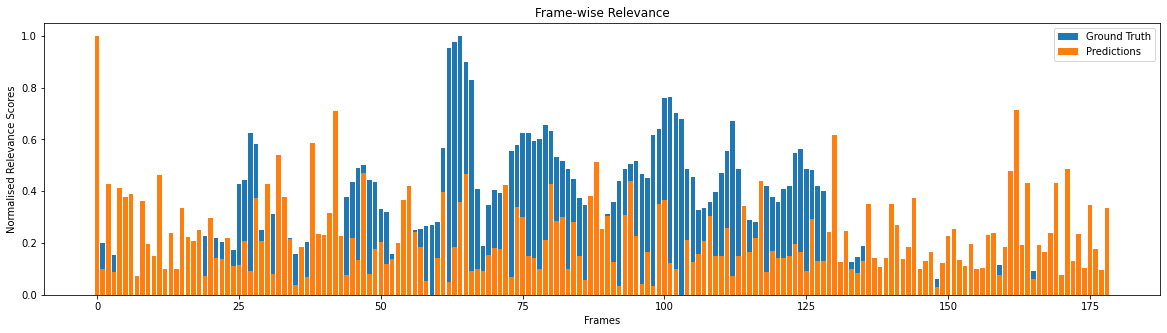

In [172]:
# plot the overlapping relevance predicition and ground truth scores

fig, ax = plt.subplots(figsize=(20,5))
ax.bar(range(len(labels_norm)), labels_norm, label='Ground Truth')
ax.bar(range(len(pred_norm)), pred_norm, label='Predictions')
plt.title('Frame-wise Relevance')

plt.xlabel('Frames')
plt.ylabel('Normalised Relevance Scores')
plt.legend()
plt.savefig('/content/drive/MyDrive/MM/temp_features/rel_score.png', dpi=300)
plt.show()

In [175]:
# Apply threshold to convert continuos scores to binary labels

THRESHOLD = 0.3

label_gt = np.array(labels_norm > THRESHOLD).astype('int')
label_pred = np.array(pred_norm > THRESHOLD).astype('int')

print(f'Accuracy score: {round(accuracy_score(label_gt, label_pred), 2)}')
print(f'Precision score: {round(precision_score(label_gt, label_pred), 2)}')
print(f'Recall score: {round(recall_score(label_gt, label_pred), 2)}')
print(f'F1 score: {round(f1_score(label_gt, label_pred), 2)}')

Accuracy score: 0.52
Precision score: 0.38
Recall score: 0.24
F1 score: 0.3
